In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


2024-05-30 08:13:43.991129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 08:13:46.434945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RANKER = False
MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
original_dataset_path = '/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet'
# level2_train_df=pl.read_parquet()
# level2_val_df=pl.read_parquet()

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [3]:
def prediction_feature_eng(df, models):
    '''
        Do feature engineering of the predictions
    '''
    df = df.with_columns(
        *[
            (pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'normalized_prediction_{model}').min().over('impression_id'))
            for model in models
        ]
    )
    
    return df

In [4]:
def load_predictions(dir, model_list):
    model_name = model_list[0]
    print(f'Loading Predictions for {model_name}')
    merged_df = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'), verbose=0)\
        .sort(by=['impression_id','article'])
    original_shape = merged_df.shape[0]
    for df in range(1, len(model_list)):
        model_name = model_list[df]
        print(f'Loading Predictions for {model_name}')
        model_predictions = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'),verbose=0).sort(by=['impression_id','article'])
        testing.assert_frame_equal(merged_df.select(['impression_id','article','target']), 
                                   model_predictions.select(['impression_id','article','target']))
        merged_df = merged_df.with_columns(
            model_predictions[f'prediction_{model_name}'].alias(f'prediction_{model_name}')
        )
        assert original_shape == merged_df.shape[0]
        
    return merged_df

In [5]:
level2_train_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_train', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [6]:
test = level2_train_df
for model in MODEL_LIST:
    if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
        test = test.with_columns(
                pl.col(f'prediction_{model}').list.first()    
            )


In [7]:
# gandalf catboost class e ranker 0.20
# lightgbm 0.15
# 0.1 MLP WD
# 0.05 dc
# MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
MODEL_WEIGHTS = [0.20, 0.20, 0.15, 0.1, 0.20, 0.1, 0.05]

In [8]:
level2_train_df = test.with_columns(
    *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
).with_columns(
    *[(MODEL_WEIGHTS[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
).with_columns(
        pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

level2_train_df = level2_train_df.with_columns(
    *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').rank().over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid']) ],
).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(    
    pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
    pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
    pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
    pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
    pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
    pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
    pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
).with_columns(
    *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
).with_columns(
    pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
    pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
    pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
)

In [9]:
quantile_95 = level2_train_df.quantile(quantile=0.95).select('horizontal_mean').item()

level2_train_df = level2_train_df.with_columns(
    pl.col('horizontal_mean').mean().over('article').alias('mean_article_horizontal_mean'),
    pl.col('avg_rank_pos').le(3.5).cast(pl.UInt32).alias('is_avg_top_3'),
    pl.col('avg_rank_pos').le(1.5).cast(pl.UInt32).alias('is_avg_top_1'),
    pl.col('horizontal_mean').gt(quantile_95).cast(pl.UInt32).alias('over_95_qt'),
    *[pl.col(f'rank_prediction_{model}').le(3).cast(pl.UInt32).alias(f'is_top_3_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'rank_prediction_{model}').le(1).cast(pl.UInt32).alias(f'is_top_1_{model}') for model in (MODEL_LIST + ['hybrid'])],
).with_columns(
    pl.sum_horizontal([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top3'),
    pl.sum_horizontal([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top1')
).with_columns(
    pl.col('agreement_top3')/pl.col('n_articles_impression').alias('normalized_agreement_top3'),
    pl.col('agreement_top1')/pl.col('n_articles_impression').alias('normalized_agreement_top1')
).drop([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])] + [f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])])



In [10]:
level2_train_df

impression_id,article,target,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,…,median_prediction_mlp,median_prediction_GANDALF,median_prediction_wd,median_prediction_dcn,median_prediction_hybrid,rank_prediction_catboost_ranker,rank_prediction_catboost_classifier,rank_prediction_light_gbm_classifier,rank_prediction_mlp,rank_prediction_GANDALF,rank_prediction_wd,rank_prediction_dcn,rank_prediction_hybrid,horizontal_mean,horizontal_min,horizontal_max,avg_rank_pos,min_rank_pos,max_rank_pos,n_articles_impression,normalized_rank_prediction_catboost_ranker,normalized_rank_prediction_catboost_classifier,normalized_rank_prediction_light_gbm_classifier,normalized_rank_prediction_mlp,normalized_rank_prediction_GANDALF,normalized_rank_prediction_wd,normalized_rank_prediction_dcn,normalized_rank_prediction_hybrid,avg_norm_rank_pos,min_norm_rank_pos,max_norm_rank_pos,mean_article_horizontal_mean,is_avg_top_3,is_avg_top_1,over_95_qt,agreement_top3,agreement_top1
u32,i32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,…,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,f64,f64
157014,9220931,0,-0.728696,0.066032,0.052614,0.072851,0.01596,0.060296,0.042829,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.116351,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.102597,0.008885,0.380989,2.0,2.0,2.0,8,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.079734,1,0,0,1.0,0.0
157014,9743870,0,1.788228,0.554978,0.660882,0.703329,0.633078,0.557787,0.584779,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,0.981257,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,8.0,7.0,8.0,8.0,7.0,7.0,6.0,8.0,0.97042,0.871446,1.0,7.375,6.0,8.0,8,1.0,0.875,1.0,1.0,0.875,0.875,0.75,1.0,0.921875,0.75,1.0,0.445495,0,0,0,0.0,0.0
157014,9769605,0,-2.277812,0.021568,0.039017,0.018487,0.010388,0.009729,0.011851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,8,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.430124,1,1,0,1.0,1.0
157014,9776223,0,0.297555,0.218479,0.217298,0.197099,0.061223,0.44846,0.535743,0.633384,0.368227,0.286688,0.260808,0.081071,0.697609,0.841377,0.39745,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,4.0,4.0

In [11]:
level2_train_df.with_columns(
    pl.col('avg_norm_rank_pos').le(3).alias('is_avg_top_3')
)

impression_id,article,target,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,…,median_prediction_mlp,median_prediction_GANDALF,median_prediction_wd,median_prediction_dcn,median_prediction_hybrid,rank_prediction_catboost_ranker,rank_prediction_catboost_classifier,rank_prediction_light_gbm_classifier,rank_prediction_mlp,rank_prediction_GANDALF,rank_prediction_wd,rank_prediction_dcn,rank_prediction_hybrid,horizontal_mean,horizontal_min,horizontal_max,avg_rank_pos,min_rank_pos,max_rank_pos,n_articles_impression,normalized_rank_prediction_catboost_ranker,normalized_rank_prediction_catboost_classifier,normalized_rank_prediction_light_gbm_classifier,normalized_rank_prediction_mlp,normalized_rank_prediction_GANDALF,normalized_rank_prediction_wd,normalized_rank_prediction_dcn,normalized_rank_prediction_hybrid,avg_norm_rank_pos,min_norm_rank_pos,max_norm_rank_pos,mean_article_horizontal_mean,is_avg_top_3,is_avg_top_1,over_95_qt,agreement_top3,agreement_top1
u32,i32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,…,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,u32,f64,f64
157014,9220931,0,-0.728696,0.066032,0.052614,0.072851,0.01596,0.060296,0.042829,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.116351,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.102597,0.008885,0.380989,2.0,2.0,2.0,8,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.079734,true,0,0,1.0,0.0
157014,9743870,0,1.788228,0.554978,0.660882,0.703329,0.633078,0.557787,0.584779,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,0.981257,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,8.0,7.0,8.0,8.0,7.0,7.0,6.0,8.0,0.97042,0.871446,1.0,7.375,6.0,8.0,8,1.0,0.875,1.0,1.0,0.875,0.875,0.75,1.0,0.921875,0.75,1.0,0.445495,true,0,0,0.0,0.0
157014,9769605,0,-2.277812,0.021568,0.039017,0.018487,0.010388,0.009729,0.011851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.435516,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,8,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.430124,true,1,0,1.0,1.0
157014,9776223,0,0.297555,0.218479,0.217298,0.197099,0.061223,0.44846,0.535743,0.633384,0.368227,0.286688,0.260808,0.081071,0.697609,0.841377,0.39745,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,…,0.327749,0.210829,0.333098,0.422934,0.4355

In [12]:
# level2_train_df = level2_train_df.join(article_features, left_on='article', right_on='article_id').join(user_features, on='impression_id')

In [13]:
level2_train_df = level2_train_df.with_columns(
    *[
            ((pl.col(field)-pl.col(field).min().over('impression_id')) / 
            (pl.col(field).max().over('impression_id')-pl.col(field).min().over('impression_id')))
            for field in ['total_inviews','total_pageviews']
     ]
).with_columns(
    (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
)

In [14]:
# level2_train_df = level2_train_df.drop(columns=['target']).join(pl.read_parquet('/home/ubuntu/experiments/preprocessing_train_small_new/train_ds.parquet'),on = ['impression_id', 'article'], how='left')

# with open(os.path.join('/home/ubuntu/experiments/preprocessing_train_small_new', 'data_info.json')) as data_info_file:
#         data_info = json.load(data_info_file)

In [15]:
# level2_train_df.with_columns(
#     (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click/inview_ratio')
# )
# level2_train_df.with_columns(
#             (((pl.col('total_inviews'))-pl.col('total_inviews').min().over('impression_id')) / 
#             (pl.col('total_inviews').max().over('impression_id')-pl.col('total_inviews').min().over('impression_id'))).alias('normalized_total_inviews'),
#             (((pl.col('total_read_time'))-pl.col('total_read_time').min().over('impression_id')) / 
#             (pl.col('total_read_time').max().over('impression_id')-pl.col('total_read_time').min().over('impression_id'))).alias('normalized_total_read_time'),
#             (((pl.col('total_pageviews'))-pl.col('total_pageviews').min().over('impression_id')) / 
#             (pl.col('total_pageviews').max().over('impression_id')-pl.col('total_pageviews').min().over('impression_id'))).alias('normalized_total_pageviews')

# )

In [16]:
if not RANKER:
    NPRATIO = 2
    starting_dataset =  pl.read_parquet(original_dataset_path).select(['impression_id','user_id','article_ids_inview','article_ids_clicked'])
    starting_dataset = starting_dataset.filter(pl.col('impression_id').is_in(level2_train_df['impression_id']))
    
    behaviors = pl.concat(
        rows.pipe(
            sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
        ).explode('article_ids_inview').drop(columns =['article_ids_clicked']).rename({'article_ids_inview' : 'article'})\
        .with_columns(pl.col('user_id').cast(pl.UInt32),
                      pl.col('article').cast(pl.Int32))\
        
         for rows in tqdm(starting_dataset.iter_slices(1000), total=starting_dataset.shape[0] // 1000)
    ).drop('user_id')
    level2_train_df = behaviors.join(level2_train_df, on = ['impression_id','article'], how = 'left')

  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_388329/2316405466.py:7: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  rows.pipe(
99it [00:07, 13.29it/s]                        


In [17]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)

categorical_columns = ['is_avg_top_3', 'is_avg_top_1', 'over_95_qt']
if RANKER:
        level2_train_df = level2_train_df.sort(by='impression_id')
        groups = level2_train_df.select('impression_id').to_numpy().flatten()
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])    
                   
level2_train_df = level2_train_df.to_pandas()
level2_train_df[categorical_columns] = level2_train_df[categorical_columns].astype('category')

group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 139.23 MB
Memory usage after optimization is: 96.84 MB
Decreased by 30.4%


0

In [18]:
if RANKER:
    params = {
        'iterations': 2000,
        'depth': 8,
        'colsample_bylevel': 0.5
    }
    catboost = CatBoostRanker(**params, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
        "iterations": 1000,
        "subsample": 0.5,
        "rsm": 0.7
    }
    catboost = CatBoostClassifier(**params, cat_features=categorical_columns)  #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

Learning rate set to 0.11739
0:	learn: 0.6364305	total: 244ms	remaining: 4m 3s
50:	learn: 0.4508996	total: 6.15s	remaining: 1m 54s
100:	learn: 0.4455319	total: 10.3s	remaining: 1m 31s
150:	learn: 0.4401818	total: 15.7s	remaining: 1m 28s
200:	learn: 0.4360737	total: 21s	remaining: 1m 23s
250:	learn: 0.4328802	total: 27.4s	remaining: 1m 21s
300:	learn: 0.4295497	total: 33s	remaining: 1m 16s
350:	learn: 0.4270791	total: 38.2s	remaining: 1m 10s
400:	learn: 0.4244255	total: 43.7s	remaining: 1m 5s
450:	learn: 0.4219355	total: 49.2s	remaining: 59.9s
500:	learn: 0.4196669	total: 55.5s	remaining: 55.3s
550:	learn: 0.4175342	total: 59.7s	remaining: 48.7s
600:	learn: 0.4155302	total: 1m 5s	remaining: 43.2s
650:	learn: 0.4136166	total: 1m 11s	remaining: 38.1s
700:	learn: 0.4117760	total: 1m 16s	remaining: 32.8s
750:	learn: 0.4100653	total: 1m 22s	remaining: 27.3s
800:	learn: 0.4081072	total: 1m 27s	remaining: 21.8s
850:	learn: 0.4064314	total: 1m 33s	remaining: 16.3s
900:	learn: 0.4046704	total: 1

In [20]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
feature_importances = catboost.get_feature_importance(train_pool)

Text(0.5, 1.0, 'Catboost Feature Importances')

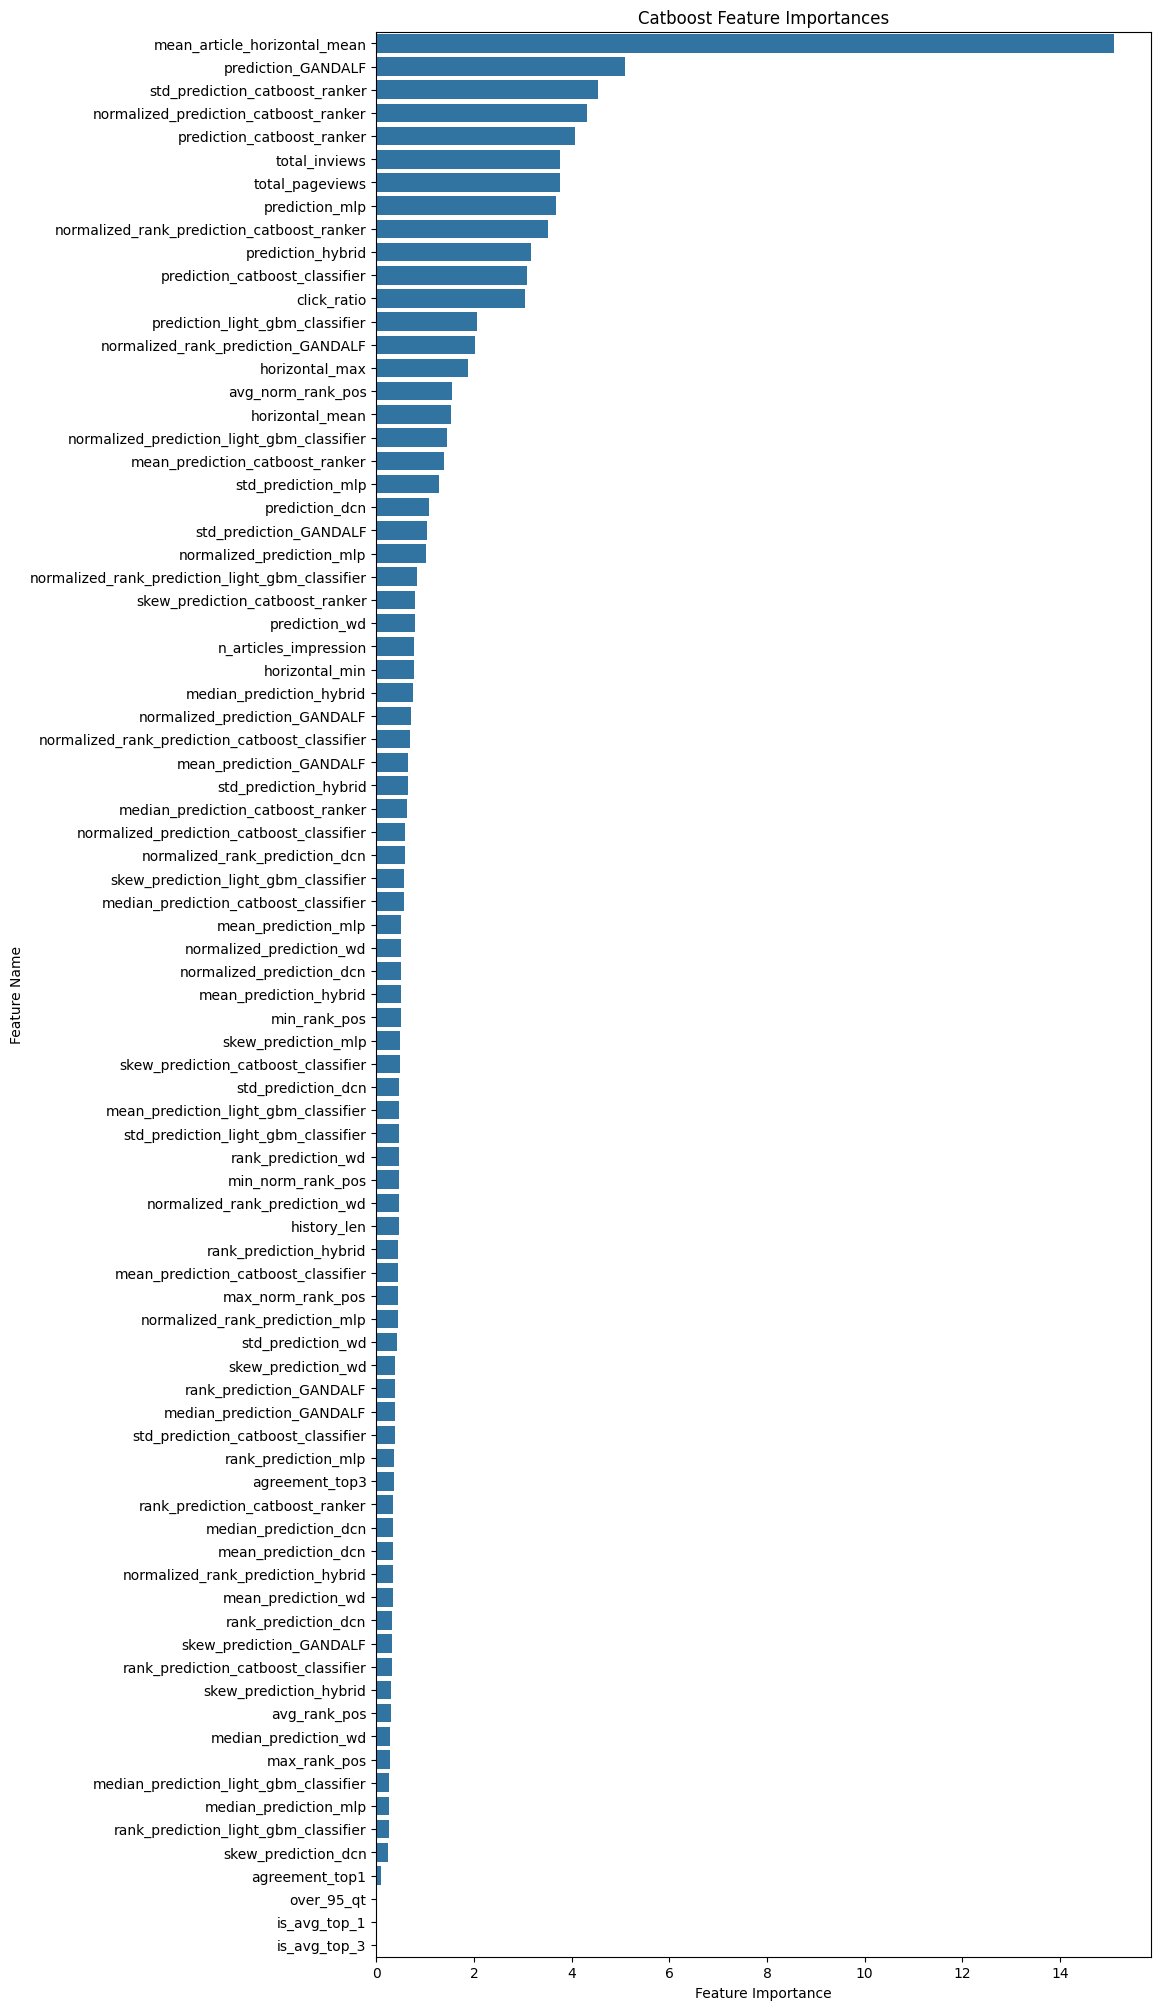

In [21]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 25))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [27]:

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [28]:
level2_val_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_validation', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [29]:
test = level2_val_df
for model in MODEL_LIST:
    if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
        test = test.with_columns(
                pl.col(f'prediction_{model}').list.first()    
            )

In [30]:
level2_val_df = test.with_columns(
    *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
).with_columns(
    *[(MODEL_WEIGHTS[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
).with_columns(
        pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

level2_val_df = level2_val_df.with_columns(
    *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').rank().over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid']) ],
).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(    
    pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
    pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
    pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
    pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
    pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
    pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
    pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
).with_columns(
    *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
).with_columns(
    pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
    pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
    pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
)


In [31]:
quantile_95 = level2_val_df.quantile(quantile=0.95).select('horizontal_mean').item()

level2_val_df = level2_val_df.with_columns(
    pl.col('horizontal_mean').mean().over('article').alias('mean_article_horizontal_mean'),
    pl.col('avg_rank_pos').le(3.5).cast(pl.UInt32).alias('is_avg_top_3'),
    pl.col('avg_rank_pos').le(1.5).cast(pl.UInt32).alias('is_avg_top_1'),
    pl.col('horizontal_mean').gt(quantile_95).cast(pl.UInt32).alias('over_95_qt'),
    *[pl.col(f'rank_prediction_{model}').le(3).cast(pl.UInt32).alias(f'is_top_3_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'rank_prediction_{model}').le(1).cast(pl.UInt32).alias(f'is_top_1_{model}') for model in (MODEL_LIST + ['hybrid'])],
).with_columns(
    pl.sum_horizontal([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top3'),
    pl.sum_horizontal([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top1')
).with_columns(
    pl.col('agreement_top3')/pl.col('n_articles_impression').alias('normalized_agreement_top3'),
    pl.col('agreement_top1')/pl.col('n_articles_impression').alias('normalized_agreement_top1')
).drop([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])] + [f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])])



In [32]:
# level2_val_df = level2_val_df.drop(columns=['target']).join(pl.read_parquet('/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet'),on = ['impression_id', 'article'], how='left')

In [33]:
level2_val_df

impression_id,article,target,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,…,median_prediction_mlp,median_prediction_GANDALF,median_prediction_wd,median_prediction_dcn,median_prediction_hybrid,rank_prediction_catboost_ranker,rank_prediction_catboost_classifier,rank_prediction_light_gbm_classifier,rank_prediction_mlp,rank_prediction_GANDALF,rank_prediction_wd,rank_prediction_dcn,rank_prediction_hybrid,horizontal_mean,horizontal_min,horizontal_max,avg_rank_pos,min_rank_pos,max_rank_pos,n_articles_impression,normalized_rank_prediction_catboost_ranker,normalized_rank_prediction_catboost_classifier,normalized_rank_prediction_light_gbm_classifier,normalized_rank_prediction_mlp,normalized_rank_prediction_GANDALF,normalized_rank_prediction_wd,normalized_rank_prediction_dcn,normalized_rank_prediction_hybrid,avg_norm_rank_pos,min_norm_rank_pos,max_norm_rank_pos,mean_article_horizontal_mean,is_avg_top_3,is_avg_top_1,over_95_qt,agreement_top3,agreement_top1
u32,i32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,…,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,f64,f64
96791,9783865,0,-0.581865,0.07266,0.093698,0.164932,0.042458,0.064278,0.076475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,…,0.387571,0.292777,0.252811,0.239868,0.56224,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,5,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.3415,1,1,0,1.6,1.6
96791,9784591,0,0.332211,0.176555,0.271684,0.405962,0.292777,0.205723,0.201436,0.578127,0.356872,0.57581,0.693803,0.487722,0.327027,0.369704,0.491484,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,…,0.387571,0.292777,0.252811,0.239868,0.56224,2.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,0.485069,0.327027,0.693803,2.375,2.0,4.0,5,0.4,0.4,0.4,0.8,0.6,0.4,0.4,0.4,0.475,0.4,0.8,0.422718,1,0,0,1.4,0.0
96791,9784679,0,0.542811,0.313949,0.306928,0.387571,0.257047,0.334262,0.274459,0.711326,0.828814,0.689829,0.640863,0.418105,0.624212,0.585748,0.650918,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,…,0.387571,0.292777,0.252811,0.239868,0.56224,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,0.643727,0.418105,0.828814,3.625,2.0,4.0,5,0.8,0.8,0.8,0.6,0.4,0.8,0.8,0.8,0.725,0.4,0.8,0.352525,0,0,0,0.4,0.0
96791,9784696,1,0.999233,0.363786,0.402803,0.512336,0.5557,0.496797,0.414477,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,…,0.387571,0.292777,0.252811,0.239868,0.56224,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,5.0,5.0,5.0,

In [34]:
# level2_val_df = level2_val_df.join(article_features, left_on='article', right_on='article_id').join(user_features, on='impression_id')

In [35]:
level2_val_df = level2_val_df.with_columns(
    *[
            ((pl.col(field)-pl.col(field).min().over('impression_id')) / 
            (pl.col(field).max().over('impression_id')-pl.col(field).min().over('impression_id')))
            for field in ['total_inviews','total_pageviews']
     ]
).with_columns(
    (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
)

In [36]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
level2_val_df[categorical_columns] = level2_val_df[categorical_columns].astype('category')

X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

In [37]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8153552692073501


In [41]:
def optimize_parameters(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, evaluation_ds: pl.DataFrame, 
                        categorical_features: List[str], group_ids: pd.DataFrame, model_class: Type = CatBoostClassifier, 
                        study_name: str = 'catboost_cls_tuning', n_trials: int = 100, storage: str = None) -> Tuple[Dict, pd.DataFrame]:    
    def objective_function(trial: optuna.Trial):
        params = get_models_params(trial, model_class, categorical_features)
        model = model_class(**params)
        if model_class == CatBoostRanker:
            model.fit(X_train, y_train, group_id=group_ids['impression_id'], verbose=50)
        elif model_class in [XGBRanker, LGBMRanker]:
            model.fit(X_train, y_train, group=group_ids.groupby('impression_id')['impression_id'].count().values)
        elif model_class == LGBMClassifier:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, verbose=100)
        if model_class in [CatBoostRanker, XGBRanker, LGBMRanker]:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        else:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        cpp_auc = CppAuc()
        return np.mean(
            [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
                for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                    prediction_ds['prediction'].to_list())]
        )
        
    study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage, load_if_exists=True)
    study.optimize(objective_function, n_trials=n_trials, n_jobs=1)
    return study.best_params, study.trials_dataframe()

In [42]:
best_params, trials_df = optimize_parameters(X_train=X_train, y_train=y_train, X_val=X_val, evaluation_ds=evaluation_ds,
                                                 categorical_features=categorical_columns, group_ids=group_ids, model_class=CatBoostClassifier,
                                                 study_name='test', n_trials=200, storage=None)

[I 2024-05-30 08:22:02,101] A new study created in memory with name: test


0:	learn: 0.6813145	total: 180ms	remaining: 10m 41s
100:	learn: 0.4639177	total: 11.9s	remaining: 6m 47s
200:	learn: 0.4556533	total: 24.3s	remaining: 6m 47s
300:	learn: 0.4532203	total: 36.8s	remaining: 6m 39s
400:	learn: 0.4518438	total: 48.7s	remaining: 6m 24s
500:	learn: 0.4506806	total: 1m	remaining: 6m 7s
600:	learn: 0.4494561	total: 1m 11s	remaining: 5m 54s
700:	learn: 0.4482472	total: 1m 24s	remaining: 5m 46s
800:	learn: 0.4471877	total: 1m 36s	remaining: 5m 35s
900:	learn: 0.4462383	total: 1m 48s	remaining: 5m 21s
1000:	learn: 0.4453942	total: 1m 59s	remaining: 5m 6s
1100:	learn: 0.4446193	total: 2m 10s	remaining: 4m 52s
1200:	learn: 0.4438603	total: 2m 21s	remaining: 4m 39s
1300:	learn: 0.4431787	total: 2m 32s	remaining: 4m 26s
1400:	learn: 0.4425262	total: 2m 44s	remaining: 4m 14s
1500:	learn: 0.4419043	total: 2m 54s	remaining: 4m
1600:	learn: 0.4412716	total: 3m 4s	remaining: 3m 47s
1700:	learn: 0.4406755	total: 3m 15s	remaining: 3m 35s
1800:	learn: 0.4401177	total: 3m 26s	

[I 2024-05-30 08:28:57,647] Trial 0 finished with value: 0.8178476092723412 and parameters: {'iterations': 3569, 'learning_rate': 0.02291874353132172, 'reg_lambda': 5.188158537098249, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS', 'subsample': 0.5712114986441857, 'random_strength': 1.317128029934691, 'fold_permutation_block': 85, 'border_count': 9, 'rsm': 0.2896614175444556, 'max_leaves': 14, 'depth': 11, 'langevin': True, 'diffusion_temperature': 806455.7299548591, 'min_data_in_leaf': 216.67365630292235, 'mvs_reg': 0.01143913987291287}. Best is trial 0 with value: 0.8178476092723412.


0:	learn: 0.6826300	total: 370ms	remaining: 17m 48s
100:	learn: 0.4610709	total: 21.1s	remaining: 9m 42s
200:	learn: 0.4524031	total: 42.1s	remaining: 9m 22s
300:	learn: 0.4497240	total: 1m 3s	remaining: 9m 7s
400:	learn: 0.4480675	total: 1m 23s	remaining: 8m 41s
500:	learn: 0.4467661	total: 1m 46s	remaining: 8m 25s
600:	learn: 0.4457334	total: 2m 7s	remaining: 8m 6s
700:	learn: 0.4448130	total: 2m 29s	remaining: 7m 47s
800:	learn: 0.4439464	total: 2m 52s	remaining: 7m 29s
900:	learn: 0.4431326	total: 3m 13s	remaining: 7m 6s
1000:	learn: 0.4424288	total: 3m 34s	remaining: 6m 44s
1100:	learn: 0.4417374	total: 3m 55s	remaining: 6m 23s
1200:	learn: 0.4410904	total: 4m 16s	remaining: 6m
1300:	learn: 0.4403980	total: 4m 36s	remaining: 5m 38s
1400:	learn: 0.4397676	total: 4m 57s	remaining: 5m 15s
1500:	learn: 0.4391812	total: 5m 16s	remaining: 4m 53s
1600:	learn: 0.4385770	total: 5m 37s	remaining: 4m 32s
1700:	learn: 0.4380160	total: 5m 59s	remaining: 4m 11s
1800:	learn: 0.4374406	total: 6m 

[I 2024-05-30 08:39:43,988] Trial 1 finished with value: 0.8182061039301661 and parameters: {'iterations': 2890, 'learning_rate': 0.018306301378522592, 'reg_lambda': 0.0004225388152640793, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1198451906967678, 'random_strength': 0.021990604206630664, 'fold_permutation_block': 87, 'border_count': 10, 'rsm': 0.13429132339614241, 'sampling_frequency': 'PerTreeLevel', 'score_function': 'Cosine', 'depth': 10, 'min_data_in_leaf': 882.416227488761}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6775392	total: 92.7ms	remaining: 4m 27s
100:	learn: 0.4624053	total: 8.66s	remaining: 3m 58s
200:	learn: 0.4578240	total: 16.9s	remaining: 3m 45s
300:	learn: 0.4560072	total: 24.6s	remaining: 3m 31s
400:	learn: 0.4544005	total: 32.3s	remaining: 3m 20s
500:	learn: 0.4523503	total: 40.4s	remaining: 3m 12s
600:	learn: 0.4505484	total: 48.3s	remaining: 3m 3s
700:	learn: 0.4492462	total: 55.7s	remaining: 2m 53s
800:	learn: 0.4480761	total: 1m 3s	remaining: 2m 45s
900:	learn: 0.4471399	total: 1m 11s	remaining: 2m 37s
1000:	learn: 0.4463199	total: 1m 19s	remaining: 2m 28s
1100:	learn: 0.4455976	total: 1m 27s	remaining: 2m 21s
1200:	learn: 0.4449527	total: 1m 34s	remaining: 2m 12s
1300:	learn: 0.4443055	total: 1m 42s	remaining: 2m 4s
1400:	learn: 0.4436412	total: 1m 49s	remaining: 1m 56s
1500:	learn: 0.4432313	total: 1m 57s	remaining: 1m 48s
1600:	learn: 0.4427314	total: 2m 4s	remaining: 1m 40s
1700:	learn: 0.4421624	total: 2m 12s	remaining: 1m 32s
1800:	learn: 0.4417993	total: 2m 

[I 2024-05-30 08:43:53,474] Trial 2 finished with value: 0.81776670166396 and parameters: {'iterations': 2887, 'learning_rate': 0.03112604746085461, 'reg_lambda': 0.06922477773602702, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS', 'subsample': 0.34497965766037414, 'random_strength': 1.9730777128064, 'fold_permutation_block': 31, 'border_count': 374, 'rsm': 0.2555441959681255, 'max_leaves': 29, 'depth': 3, 'langevin': True, 'diffusion_temperature': 169.40899988461123, 'min_data_in_leaf': 282.4229909818001, 'mvs_reg': 0.0002881541793289005}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6239517	total: 31ms	remaining: 15s
100:	learn: 0.4577419	total: 4.33s	remaining: 16.4s
200:	learn: 0.4544806	total: 9.44s	remaining: 13.3s
300:	learn: 0.4528119	total: 13.7s	remaining: 8.33s
400:	learn: 0.4517931	total: 17.6s	remaining: 3.63s
483:	learn: 0.4509849	total: 21.1s	remaining: 0us


[I 2024-05-30 08:44:31,226] Trial 3 finished with value: 0.8172266066811429 and parameters: {'iterations': 484, 'learning_rate': 0.180306314316547, 'reg_lambda': 785.508231735594, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'subsample': 0.3743747653280699, 'random_strength': 20.499573551846982, 'fold_permutation_block': 22, 'border_count': 24, 'rsm': 0.20728463188411667, 'sampling_frequency': 'PerTreeLevel', 'score_function': 'L2', 'depth': 2, 'mvs_reg': 393.33164228573287}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6444702	total: 136ms	remaining: 9m 40s
100:	learn: 0.4504180	total: 10.8s	remaining: 7m 28s
200:	learn: 0.4482462	total: 20.9s	remaining: 7m 3s
300:	learn: 0.4463838	total: 31.9s	remaining: 7m 1s
400:	learn: 0.4449464	total: 42.4s	remaining: 6m 50s
500:	learn: 0.4436918	total: 53.1s	remaining: 6m 40s
600:	learn: 0.4426164	total: 1m 3s	remaining: 6m 31s
700:	learn: 0.4415830	total: 1m 14s	remaining: 6m 20s
800:	learn: 0.4407274	total: 1m 23s	remaining: 6m 4s


Training has stopped (degenerate solution on iteration 806, probably too small l2-regularization, try to increase it)
[I 2024-05-30 08:46:15,256] Trial 4 finished with value: 0.817805310289532 and parameters: {'iterations': 4282, 'learning_rate': 0.09036714618593292, 'reg_lambda': 0.000596092790024427, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS', 'subsample': 0.2517750355472477, 'random_strength': 0.00011636735195074889, 'fold_permutation_block': 46, 'border_count': 12, 'rsm': 0.6797406349437218, 'max_leaves': 26, 'depth': 4, 'langevin': True, 'diffusion_temperature': 143434.71845072854, 'min_data_in_leaf': 620.2151717964547, 'mvs_reg': 0.117761987445623}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6387943	total: 96.8ms	remaining: 1m 56s
100:	learn: 0.4554188	total: 21.4s	remaining: 3m 53s
200:	learn: 0.4361601	total: 42.2s	remaining: 3m 29s
300:	learn: 0.4229143	total: 1m 1s	remaining: 3m 3s
400:	learn: 0.4137359	total: 1m 21s	remaining: 2m 42s
500:	learn: 0.4056944	total: 1m 41s	remaining: 2m 21s
600:	learn: 0.3979535	total: 2m	remaining: 2m
700:	learn: 0.3908571	total: 2m 19s	remaining: 1m 39s
800:	learn: 0.3840971	total: 2m 38s	remaining: 1m 18s
900:	learn: 0.3776078	total: 2m 58s	remaining: 59.2s


Training has stopped (degenerate solution on iteration 930, probably too small l2-regularization, try to increase it)
[I 2024-05-30 08:49:41,465] Trial 5 finished with value: 0.8133200068401477 and parameters: {'iterations': 1200, 'learning_rate': 0.11702995337203786, 'reg_lambda': 8.084275951966957e-05, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6012011562458733, 'random_strength': 17.577365103912662, 'fold_permutation_block': 18, 'border_count': 480, 'rsm': 0.24643135673610633, 'max_leaves': 49, 'depth': 6, 'langevin': False, 'min_data_in_leaf': 70.18546326352687}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6655092	total: 409ms	remaining: 29m 3s
100:	learn: 0.4422721	total: 28.6s	remaining: 19m 39s
200:	learn: 0.4336919	total: 52.8s	remaining: 17m 48s
300:	learn: 0.4279525	total: 1m 16s	remaining: 16m 47s
400:	learn: 0.4225272	total: 1m 38s	remaining: 15m 45s
500:	learn: 0.4177681	total: 2m	remaining: 15m 9s
600:	learn: 0.4138131	total: 2m 21s	remaining: 14m 22s
700:	learn: 0.4094714	total: 2m 55s	remaining: 14m 54s
800:	learn: 0.4057407	total: 3m 28s	remaining: 15m 3s
900:	learn: 0.4021208	total: 4m 2s	remaining: 15m 4s
1000:	learn: 0.3991090	total: 4m 34s	remaining: 14m 54s
1100:	learn: 0.3957945	total: 5m 9s	remaining: 14m 49s
1200:	learn: 0.3930458	total: 5m 43s	remaining: 14m 37s
1300:	learn: 0.3899989	total: 6m 16s	remaining: 14m 19s
1400:	learn: 0.3873083	total: 6m 49s	remaining: 13m 57s
1500:	learn: 0.3844415	total: 7m 22s	remaining: 13m 35s
1600:	learn: 0.3816937	total: 7m 55s	remaining: 13m 11s
1700:	learn: 0.3791216	total: 8m 28s	remaining: 12m 46s
1800:	learn: 0.37

[I 2024-05-30 09:13:33,979] Trial 6 finished with value: 0.8119943552309737 and parameters: {'iterations': 4268, 'learning_rate': 0.049311654441381234, 'reg_lambda': 11.83917471633977, 'grow_policy': 'Depthwise', 'bootstrap_type': 'MVS', 'subsample': 0.5782787874007351, 'random_strength': 0.5073382761416022, 'fold_permutation_block': 15, 'border_count': 345, 'rsm': 0.13895385489447523, 'sampling_frequency': 'PerTreeLevel', 'score_function': 'Cosine', 'depth': 8, 'min_data_in_leaf': 944.0131451379685, 'mvs_reg': 4.062825226601303}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6229198	total: 119ms	remaining: 18.4s
100:	learn: 0.4489359	total: 20.1s	remaining: 10.9s
155:	learn: 0.4450727	total: 31.1s	remaining: 0us


[I 2024-05-30 09:14:28,861] Trial 7 finished with value: 0.817435248189186 and parameters: {'iterations': 156, 'learning_rate': 0.14412648249685067, 'reg_lambda': 3.7495162077571016, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS', 'subsample': 0.4399781970804443, 'random_strength': 1.4190108080799624, 'fold_permutation_block': 86, 'border_count': 34, 'rsm': 0.12844014685215271, 'max_leaves': 39, 'depth': 5, 'langevin': True, 'diffusion_temperature': 154.73634769592638, 'min_data_in_leaf': 716.0245350325517, 'mvs_reg': 7.2519903540404975}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6080093	total: 181ms	remaining: 8m 47s
100:	learn: 0.4065262	total: 32.5s	remaining: 15m 6s
200:	learn: 0.3622196	total: 53s	remaining: 11m 57s
300:	learn: 0.3258694	total: 1m 14s	remaining: 10m 50s
400:	learn: 0.2941470	total: 1m 39s	remaining: 10m 22s
500:	learn: 0.2654434	total: 2m 3s	remaining: 9m 57s
600:	learn: 0.2405411	total: 2m 29s	remaining: 9m 35s
700:	learn: 0.2166857	total: 2m 54s	remaining: 9m 13s
800:	learn: 0.1953846	total: 3m 20s	remaining: 8m 49s
900:	learn: 0.1765775	total: 3m 32s	remaining: 7m 56s
1000:	learn: 0.1592279	total: 3m 58s	remaining: 7m 38s
1100:	learn: 0.1441160	total: 4m 27s	remaining: 7m 22s
1200:	learn: 0.1304717	total: 4m 57s	remaining: 7m 5s
1300:	learn: 0.1178939	total: 5m 23s	remaining: 6m 43s
1400:	learn: 0.1066467	total: 5m 55s	remaining: 6m 25s
1500:	learn: 0.0969371	total: 6m 23s	remaining: 6m 2s
1600:	learn: 0.0880226	total: 6m 50s	remaining: 5m 38s
1700:	learn: 0.0800362	total: 7m 20s	remaining: 5m 15s
1800:	learn: 0.0728937	tota

[I 2024-05-30 09:28:06,460] Trial 8 finished with value: 0.8006944910794017 and parameters: {'iterations': 2920, 'learning_rate': 0.1808721307219103, 'reg_lambda': 0.530591487259682, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5848058697050796, 'random_strength': 1.5109083347957872, 'fold_permutation_block': 27, 'border_count': 58, 'rsm': 0.48188858341645835, 'sampling_frequency': 'PerTreeLevel', 'score_function': 'Cosine', 'depth': 10}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6734469	total: 355ms	remaining: 20m 5s
100:	learn: 0.4415065	total: 21.2s	remaining: 11m 32s
200:	learn: 0.4256038	total: 38.6s	remaining: 10m 14s
300:	learn: 0.4107985	total: 58.7s	remaining: 10m 3s
400:	learn: 0.3975979	total: 1m 18s	remaining: 9m 47s
500:	learn: 0.3874505	total: 1m 39s	remaining: 9m 37s
600:	learn: 0.3755170	total: 1m 59s	remaining: 9m 16s
700:	learn: 0.3641664	total: 2m 17s	remaining: 8m 50s
800:	learn: 0.3547926	total: 2m 38s	remaining: 8m 33s
900:	learn: 0.3439704	total: 2m 59s	remaining: 8m 17s
1000:	learn: 0.3347962	total: 3m 21s	remaining: 8m 2s
1100:	learn: 0.3255862	total: 3m 43s	remaining: 7m 46s
1200:	learn: 0.3161598	total: 4m 6s	remaining: 7m 30s
1300:	learn: 0.3072147	total: 4m 27s	remaining: 7m 10s
1400:	learn: 0.2987744	total: 4m 47s	remaining: 6m 50s
1500:	learn: 0.2903234	total: 5m 9s	remaining: 6m 30s
1600:	learn: 0.2839735	total: 5m 29s	remaining: 6m 10s
1700:	learn: 0.2761382	total: 5m 49s	remaining: 5m 48s
1800:	learn: 0.2684553	tota

Training has stopped (degenerate solution on iteration 2031, probably too small l2-regularization, try to increase it)
[I 2024-05-30 09:35:29,032] Trial 9 finished with value: 0.8086149622315825 and parameters: {'iterations': 3398, 'learning_rate': 0.03544902703348976, 'reg_lambda': 6.236778775133334e-05, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'subsample': 0.2259222925799083, 'random_strength': 0.00041029941370619174, 'fold_permutation_block': 74, 'border_count': 25, 'rsm': 0.1520472833740103, 'sampling_frequency': 'PerTreeLevel', 'score_function': 'Cosine', 'depth': 10, 'mvs_reg': 0.00024768871614022934}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6892789	total: 50ms	remaining: 1m 30s
100:	learn: 0.5129339	total: 9.91s	remaining: 2m 46s
200:	learn: 0.4751007	total: 22s	remaining: 2m 55s
300:	learn: 0.4646091	total: 32.5s	remaining: 2m 41s
400:	learn: 0.4603958	total: 42.4s	remaining: 2m 28s
500:	learn: 0.4582622	total: 53.6s	remaining: 2m 19s
600:	learn: 0.4568630	total: 1m 4s	remaining: 2m 9s
700:	learn: 0.4558275	total: 1m 14s	remaining: 1m 56s
800:	learn: 0.4550512	total: 1m 24s	remaining: 1m 44s
900:	learn: 0.4544061	total: 1m 34s	remaining: 1m 34s
1000:	learn: 0.4538073	total: 1m 44s	remaining: 1m 23s
1100:	learn: 0.4533116	total: 1m 54s	remaining: 1m 13s
1200:	learn: 0.4528846	total: 2m 3s	remaining: 1m 1s
1300:	learn: 0.4524934	total: 2m 13s	remaining: 51.4s
1400:	learn: 0.4521244	total: 2m 22s	remaining: 40.8s
1500:	learn: 0.4517636	total: 2m 31s	remaining: 30.2s
1600:	learn: 0.4514495	total: 2m 41s	remaining: 20.2s
1700:	learn: 0.4511730	total: 2m 50s	remaining: 10s
1800:	learn: 0.4508931	total: 3m 1s	remain

[I 2024-05-30 09:39:01,595] Trial 10 finished with value: 0.8165244300370524 and parameters: {'iterations': 1801, 'learning_rate': 0.007001061571301179, 'reg_lambda': 0.0037464846784701408, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.058852874360759075, 'random_strength': 0.007388092988595419, 'fold_permutation_block': 100, 'border_count': 148, 'rsm': 0.05231962747553289, 'sampling_frequency': 'PerTree', 'score_function': 'L2', 'depth': 8, 'min_data_in_leaf': 946.3927662275767}. Best is trial 1 with value: 0.8182061039301661.


0:	learn: 0.6850167	total: 289ms	remaining: 17m 34s
100:	learn: 0.4641397	total: 29.5s	remaining: 17m 16s
200:	learn: 0.4485392	total: 56.9s	remaining: 16m 15s
300:	learn: 0.4431331	total: 1m 22s	remaining: 15m 12s
400:	learn: 0.4395268	total: 1m 48s	remaining: 14m 41s


[W 2024-05-30 09:41:01,361] Trial 11 failed with parameters: {'iterations': 3647, 'learning_rate': 0.013774532423113687, 'reg_lambda': 0.011689317452105878, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6933156917756467, 'random_strength': 0.028155905803291855, 'fold_permutation_block': 68, 'border_count': 8, 'rsm': 0.07770985409412728, 'sampling_frequency': 'PerTree', 'score_function': 'Cosine', 'depth': 8, 'min_data_in_leaf': 333.1391655333258} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/ubuntu/RecSysChallenge2024/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_388329/2766333996.py", line 14, in objective_function
    model.fit(X_train, y_train, verbose=100)
  File "/home/ubuntu/RecSysChallenge2024/.venv/lib/python3.10/site-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, 

KeyboardInterrupt: 